## NECESSARY IMPORTS

In [1]:
#NECESSARY IMPORTS
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#To show all columns
pd.options.display.max_columns = None

In [2]:
!pip install nltk
import nltk

In [3]:
#to import all functions from functions_t.ipnyb created file
!pip install nbimporter
import nbimporter
from functions_t import *

## GETTING THE DATA

## BARCELONA

In [5]:
OUTPUT_FILENAME = "./Data/barcelonian_data/BarcelonianProjects.json"

with open(OUTPUT_FILENAME, 'r', encoding='utf-8') as f:
    list = json.load(f)
dataframe_BCN=pd.DataFrame.from_dict(list)
dataframe_BCN[:3]

,name,description,status,activities,topic,bcn_url,official_url
0,Beepath,Beepath es una herramienta que permite estudia...,activo periódicamente,"Programa en los Barrios, Programa en las escue...",social,https://www.barcelona.cat/barcelonaciencia/es/...,http://www.ub.edu/opensystems/ca/projectes/bee...
1,BioBlitz Barris,BioBlitz Barris pretende utilitzar el método B...,activo periódicamente,"Programa en los Barrios, Fiesta de la Ciencia,...",ambiental,https://www.barcelona.cat/barcelonaciencia/es/...,https://bioblitzbarris.net/
2,BioBlitzBcn,Un BioBlitz es un censo exhaustivo y colaborat...,activo periódicamente,"Programa los Barrios, Comunidad de práctica",ambiental,https://www.barcelona.cat/barcelonaciencia/es/...,http://bioblitzbcn.museuciencies.cat/


In [6]:
#ADD ID COLUMN (INDEX) and drop url columns
dataframe_BCN=dataframe_BCN.reset_index()
#dataframe_BCN=dataframe_BCN.drop(columns=["bcn_url", "official_url"])

## Text mining: analysing the description fields: getting the wordcloud, the length distribution and the most relevant words by using tf-idf

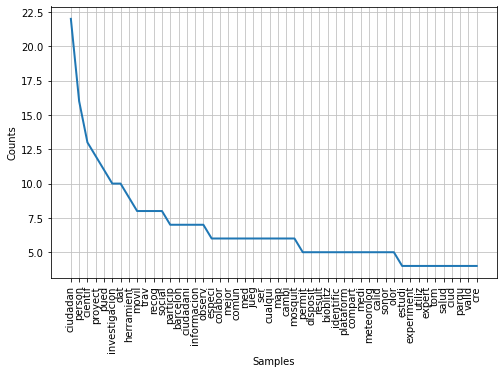

Displaying 1 of 1 matches:
al ser viv general riunet herramient educ interact gui cualqui person diagnost

The vocabulary is composed by 20 words 



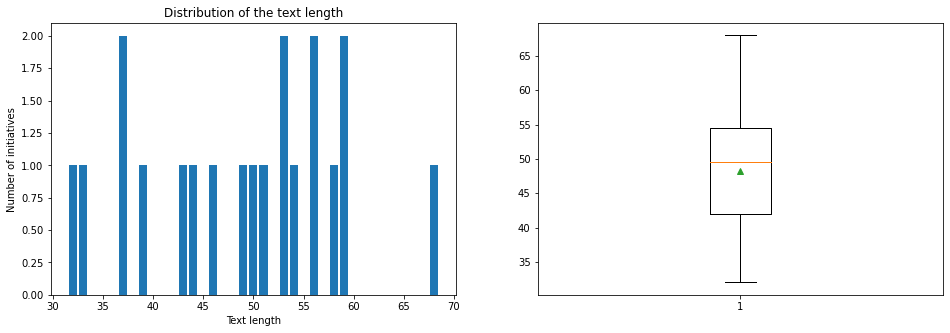

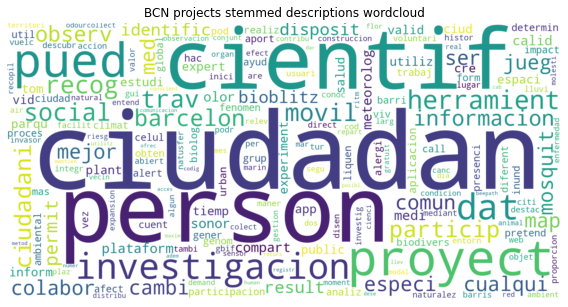

In [7]:
dataframe_BCN['description_clean'] = dataframe_BCN.description.apply(lambda text: clean_text(text))
# Get the nltk.Text object
description_tokens = convert_to_nltk_text(dataframe_BCN, "description_clean")
description_std_tokens = standardize_text(description_tokens, "spanish")
dataframe_BCN['description_clean'] = dataframe_BCN.description_clean.apply(lambda text: standardize_text(text, "spanish"))

plt.figure(figsize = (8,5))
nltk.FreqDist(description_std_tokens).plot(50)

nltk.FreqDist(description_std_tokens).most_common(20)

description_std_tokens.concordance("educ")

plot_text_length_distribution(dataset = dataframe_BCN,
                              text_field = 'description_clean')

bag_of_words_description, stemmized_description=get_bagofwords(dataframe_BCN, "description", "spanish")
plot_wordcloud("BCN projects stemmed descriptions wordcloud", stemmized_description)

#sorted(stemmized_description.items(), key= lambda x: x[1], reverse=True)

In [8]:
tfidfs = []
dataframe_BCN["description_resultwords"]=np.empty((len(dataframe_BCN), 0)).tolist()
document_size=len(dataframe_BCN)
# calculate tf
for index, row in dataframe_BCN.iterrows():
    tfidf = TFIDF(row["description_clean"])
    tfidf.tf()
    tfidfs.append(tfidf)
# calculate idf

all_text = [tfidf.text for tfidf in tfidfs]
    
for i, tfidf in enumerate(tfidfs):
    tfidf.idf(all_text, document_size)
    tfidf.tf_idf()
    result_df = tfidf.text_df.sort_values('tfidf', ascending=False).head(5)  # sort and take top 5
    result_words = []
    for index, row in result_df.iterrows():
        result_words.append((row.word, row.tfidf))
        dataframe_BCN.loc[i, "description_resultwords"].append((row.word, row.tfidf))    

## DEDUCE if they require a phone

In [9]:
phone=["dispositivo", "móvil", "aplicación", "app"]
dataframe_BCN["phone"]=False
phones=0

for index, row in dataframe_BCN.iterrows():
    if any(x.lower() in row['description'].lower() for x in phone):
        dataframe_BCN.loc[index,["phone"]]=True
        phones=phones+1
print(phones, " out of ",len(dataframe_BCN), " projects mention phones.")

8  out of  20  projects mention phones.


### TOPICS

In [10]:
dataframe_BCN.topic.unique()

array(['social', 'ambiental', 'salud', 'ambiental, salud', ''],
      dtype=object)

<Figure size 432x288 with 0 Axes>

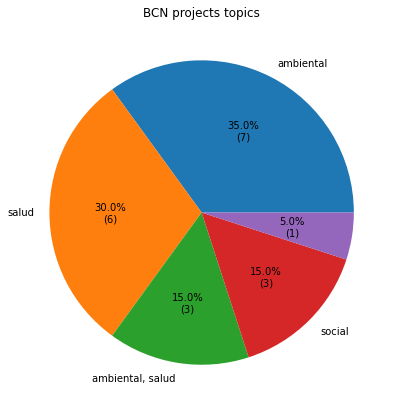

In [11]:
plot_pie(dataframe_BCN, "topic", "BCN projects topics")

### STATUS

<Figure size 432x288 with 0 Axes>

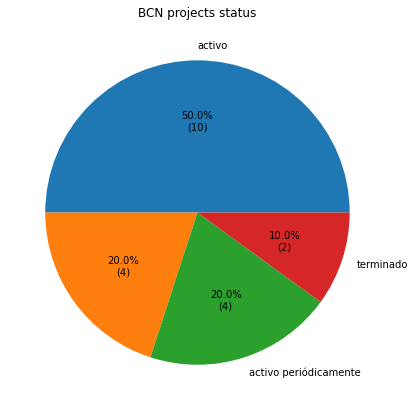

In [12]:
plot_pie(dataframe_BCN, "status", "BCN projects status")

### ACTIVITIES

In [13]:
#dataframe_BCN['activities'] = dataframe_BCN.activities.apply(lambda text: re.sub(".", "", text))

df_actividades_bcn = pd.DataFrame(columns=['act', 'num_times_appears', 'list_projects'])
for index, row in dataframe_BCN.iterrows():
    dataframe_BCN.loc[index, "activities"]= dataframe_BCN.loc[index, "activities"].replace('.', '')
    dataframe_BCN.loc[index, "activities"]= dataframe_BCN.loc[index, "activities"].replace('Programa los Barrios', 'Programa en los Barrios')
    #clean= dataframe_BCN.loc[index, "activities"].replace('.', '')
    for act in dataframe_BCN.loc[index, "activities"].split(", "):
        if act not in df_actividades_bcn['act'].unique():
            new_row={'act':act, 'num_times_appears':1, 'list_projects':[row["index"]]}
            df_actividades_bcn= df_actividades_bcn.append(new_row, ignore_index=True)
        else:
            index = df_actividades_bcn.index[df_actividades_bcn['act'] == act]
            df_actividades_bcn.loc[index,['num_times_appears']] = df_actividades_bcn[df_actividades_bcn['act'] == act].num_times_appears +1

df_actividades_bcn = df_actividades_bcn.sort_values(by=['num_times_appears'], ascending=False)
df_actividades_bcn

,act,num_times_appears,list_projects
4,Comunidad de práctica,19,[0]
2,Fiesta de la Ciencia,14,[0]
0,Programa en los Barrios,10,[0]
1,Programa en las escuelas,9,[0]
5,Calidoscopi 2019,9,[4]
6,Bienal de Ciencia 2018,5,[7]
3,Safari del ECSA 2015,3,[0]
7,Estación Ciudad 2017,1,[13]


In [14]:
#EXPORT TO EXCEL
with pd.ExcelWriter('dataframe_BCN.xlsx', options={'strings_to_urls': False}) as writer:
        dataframe_BCN.to_excel(writer, 'dataframe_BCN')
dataframe_BCN[:3]

,index,name,description,status,activities,topic,bcn_url,official_url,description_clean,description_resultwords,phone
0,0,Beepath,Beepath es una herramienta que permite estudia...,activo periódicamente,"Programa en los Barrios, Programa en las escue...",social,https://www.barcelona.cat/barcelonaciencia/es/...,http://www.ub.edu/opensystems/ca/projectes/bee...,beepath herramient permit estudi movil human r...,"[(direct, 0.124), (comunicacion, 0.062), (cons...",True
1,1,BioBlitz Barris,BioBlitz Barris pretende utilitzar el método B...,activo periódicamente,"Programa en los Barrios, Fiesta de la Ciencia,...",ambiental,https://www.barcelona.cat/barcelonaciencia/es/...,https://bioblitzbarris.net/,bioblitz barris pretend utilitz metod bioblitz...,"[(bioblitz, 0.102), (barris, 0.082), (cod, 0.0...",False
2,2,BioBlitzBcn,Un BioBlitz es un censo exhaustivo y colaborat...,activo periódicamente,"Programa en los Barrios, Comunidad de práctica",ambiental,https://www.barcelona.cat/barcelonaciencia/es/...,http://bioblitzbcn.museuciencies.cat/,bioblitz cens exhaust colabor especi biolog ar...,"[(biolog, 0.177), (bioblitz, 0.097), (cuent, 0...",False
